### CS 575 Final Project

Description and solution to the final project in CS 575 for fall semester 2025.

- Mike Goodrich
- Brigham Young University
- March 2025

---

### Prior Project

The previous project constructed the person-person network by
- constructing a knowledge graph with the following 
  - node types
    - person
    - thread
    - channel
  - edge types
    - posted in thread
    - posted in channel
    - replied to
- using one-mode projection to form the person-person network

The project then had students apply node metrics and graph partitioning metrics to find 
- influential nodes
- community structures and inter-community bridges

Given the influential nodes and community structures, students then had to 
- develop a strategy for choosing early adopters so that a complex contagion could spread on the network
- simulate the complex contagion on the network to see how well their design worked

---


### Proposed Project

The proposed project shifts from social structure to semantic structure. A different graph schema will be used so that students can build a network that connects related messages. The proposed learning objectives are

**Learning Objectives**
- Design a knowledge graph schema based on textual content.
- Apply embedding techniques to short, informal text.
- Use GNNs to embed nodes based on content and relationships.
- Interpret clusters of embedded text data.

I've worked with ChatGPT-4o to create the following specification. The rest of this notebook will elaborate and implement the specification.

1. **Build the Knowledge Graph**
  - Nodes: Messages (from edges.csv — each message is a unique edge with content).
  - Edges between messages (Students will use edges.csv and nodes.csv to map messages to threads/channels/authors.):
    - Same author
    - Same recipient
    - Same channel
    - Same thread
    - Optional: same author and receiver
    - Optional: time adjacency (within X minutes in same thread)


2. **Form "Related Message" Network**
  - Find biadjacency matrix with messages as columns
  - Use one-mode projection to form adjacency matrix for which messages are related to which other messages

3. **Extract Feature Vectors for Messages**
  - Use one of the feature extraction strategies above. These are precanned methods for extracting features that won't be taught in class.
  - The feature vector for each message node is initialized with its vector.

4. **Train a GNN to Learn Embeddings**
  - Use a simple GCN or GAT with 2–3 layers.
  - Train using unsupervised objectives (e.g., Deep Graph Infomax or contrastive loss). I propose to use _reconstruction loss_ since I'll have taught that
  - Alternatively, treat it as node classification if you can weakly label messages by topics (optional).

5. **Visualize and Cluster**
  - Project the learned node embeddings using t-SNE or UMAP.
  - Cluster using KMeans or DBSCAN.
  - Display representative messages from each cluster.

6. **Analyze**
  - What kinds of messages cluster together?
  - Do clusters correlate with authors, channels, threads?
  - How do different edge definitions affect the graph (e.g., adding reply edges vs. not)?

The remainder of this notebook will go through these steps.

---

### Build the Knowledge Graph

#### Step 1: Extract Nodes

Read the `nodes.csv` file into a pandas dataframe and inspect the header. 


In [85]:
import pandas as pd
nodes_data = pd.read_csv('cs236_data/nodes.csv')
nodes_data.head()

,node,type,value
0,530,person,TA
1,0,person,TA
2,80,person,Student
3,531,person,Student
4,162,person,Student


- The entries in the node column are unique _node IDs_
- The entries in the node column are _node types_
  - person
  - thread
  - channel
- The entries in the value column depend on the node type
  - person values are one of
    - TA
    - Student
    - Instrutor
  - channel values are one of the channels in the Discord server
    - general
    - project 1
    - etc
  - thread values are the names given to the thread which are one of the following
    - names chosen by the person initiating the thread
    - first few words from the message from which the thread spawned

We can illustrate this relationship.

<img src="figures/nodes_organization.png" alt="Hierarchical relationship among nodes in nodes.csv" width = "800">

Start building the knowledge graph by extracting three node types: person, channel, thread.  Each vertex in the graph will have three properties:
- unique vertex ID (which will not be the same as the node ID)
- vertex type
  - person
  - channel
  - thread
- vertex value
  - type of person
  - channel name
  - thread name

A _lurker_ is a member of a Discord server who never posts anything. I don't want to add lurkers as nodes to the graph because they won't be part of anything interesting.

In [86]:
node_set: set[int] = set(nodes_data['node'])
print(len(node_set))

edges_data = pd.read_csv('cs236_data/edges_with_labels.csv')
edge_set: set[int] = set(edges_data['source']) | set(edges_data['target'])

lurkers: set[int] = node_set - edge_set
for i in lurkers:
    if i%10 == 0:
        print(f"node {i} is never part of a message")

671
node 530 is never part of a message
node 540 is never part of a message
node 550 is never part of a message
node 560 is never part of a message
node 570 is never part of a message
node 580 is never part of a message
node 590 is never part of a message
node 600 is never part of a message
node 610 is never part of a message
node 620 is never part of a message
node 630 is never part of a message
node 640 is never part of a message
node 650 is never part of a message
node 660 is never part of a message
node 670 is never part of a message


In [87]:
import networkx as nx
from typing import Tuple

def add_nodes_from_node_dataframe(dataframe: pd.DataFrame,
                                  G: nx.Graph,
                                  lurkers: set[int]
                                  ) -> Tuple[nx.Graph, dict[int, int]]:
    """ 
        Take an empty graph and populate it with nodes.
        Inputs
          • dataframe is a pandas dataframe for node types
          • G is a graph with no edges and no nodes
        Output: 
          • A graph populated with nodes. Each node has the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
          • A dictionary that allows the vertex ID in the graph to be looked up
            from node ID in the file
        Note attributes
          • The node type is a string. 
          • The node value is a string, whose interpretation depends on the node type
    """

    # Error checks
    if len(G) > 0:
        raise ValueError("Graph must be empty")
    
    nodeID_to_vertexID: dict[int, int] = dict()
    vertex_ID: int = 0

    # For each row in the nodes.csv dataframe, number the entries and skip lurkers
    for _, row in dataframe.iterrows():
        if int(row['node']) not in lurkers:
          G.add_node(vertex_ID,
                    node_ID = int(row['node']), 
                    node_type = str(row['type']),
                    node_value = str(row['value']))
          nodeID_to_vertexID[row['node']] = vertex_ID
          vertex_ID += 1
    return G, nodeID_to_vertexID


Confirm that we are getting the node that we want. 

In [88]:
G = nx.Graph()
G, nodeID_to_vertexID = add_nodes_from_node_dataframe(nodes_data, G, lurkers)
for node, attrs in G.nodes(data=True):
    print(f"node {node} has attributes: ID = {attrs.get('node_ID')}, type = {attrs.get('node_type')}, value = {attrs.get('node_value')[:2]}")
    if node > 10: 
        break

node 0 has attributes: ID = 0, type = person, value = TA
node 1 has attributes: ID = 80, type = person, value = St
node 2 has attributes: ID = 162, type = person, value = St
node 3 has attributes: ID = 7, type = person, value = St
node 4 has attributes: ID = 170, type = person, value = St
node 5 has attributes: ID = 158, type = person, value = St
node 6 has attributes: ID = 97, type = person, value = St
node 7 has attributes: ID = 172, type = person, value = St
node 8 has attributes: ID = 173, type = person, value = St
node 9 has attributes: ID = 65, type = person, value = St
node 10 has attributes: ID = 4, type = person, value = St
node 11 has attributes: ID = 179, type = person, value = TA


Look at graph to make sure things make sense

In [89]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from typing import Hashable

def show_graph(G: nx.Graph, 
               categories: list[str],
               pos: dict[Hashable, Tuple[float,float]] | None = None,
               title: str = "Graph from pandas dataframe"
               ) -> None:
    color_template: dict[str, str] = {'person': 'lightblue', 
                                    'thread': 'y', 
                                    'channel': 'salmon', 
                                    'message': 'm'}
    # Need to add error checking. That is where the categories argument will be used
    node_colors: list[str] = []
    for node in G.nodes():
        if G.nodes[node]['node_type'] == 'name':
            node_colors.append(color_template['name'])
        elif len(G.nodes[node]['node_type'].split(",")) > 1:
            node_colors.append(color_template['combo'])
        else:
            node_colors.append(color_template[G.nodes[node]['node_type']])

    plt.figure()
    #pos = nx.spring_layout(G)
    #pos = nx.nx_pydot.pydot_layout(G, prog="neato")
    if pos is None:
        try:
            pos = nx.nx_pydot.graphviz_layout(G, prog="neato")
        except Exception as e:
            print(f"Graphviz layout failed, falling back to spring_layout: {e}")
            pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color = node_colors, alpha=0.5,node_size=20 )
    nx.draw_networkx_edges(G, pos, edge_color="lightgray", width=0.5)
    
    # create and add legend
    legend_patches = [mpatches.Patch(color=color, label=category) for category, 
                    color in color_template.items() if category in categories]
    _ = plt.legend(handles=legend_patches, title="Node Types", loc="best")

    # Add the title
    _ = plt.title(title)
    _ = plt.axis('off')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


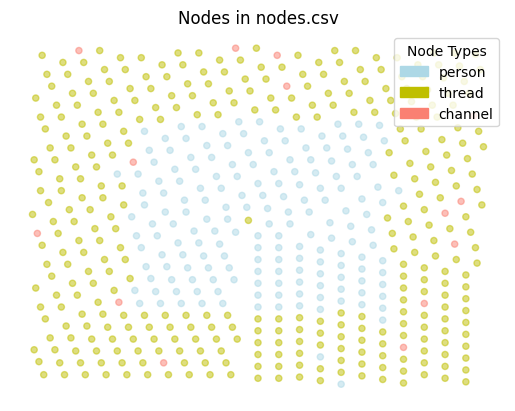

In [90]:
show_graph(G, ["person", "thread", "channel"], title = "Nodes in nodes.csv")

#### Step 2: Add Node for Each Message

Add a node for each message in `edges.csv`. The columns are
- _source_: the source of the message
- _target_: the destination of the message
- _edge type_: determined by the destimation of the message
  - `posted_in_channel` means the source is a person and the target is a channel
  - `replied_to` means the source is a person and the target is a person
  - `posted_in_thread` mens the source is a person and the target is a channel
  - `thread_in_channel` means the source is a thread and the thread is in a channel
- _content_: determined by the edge type
  - the message if the edge type is anything but `thread_in_channel`
  - empty if the edge type is `thread_in_channel`

We can illustrate this relationship.

<img src="figures/edges_organization.png" alt="Hierarchical relationship among edges in edges.csv" width = "600">

Let's confirm this pattern.

In [91]:
edges_data.head()

,source,target,edge_type,content,label
0,0,1,posted_in_channel,Project Submission Question,business
1,0,0,replied_to,I'm feeling better so I'll be in at around 11:30,business
2,0,2,replied_to,Nope,small talk
3,0,3,replied_to,Will there be any TAs today?,business
4,0,4,replied_to,"Yes, see the <#1148663286267641906> for specif...",business


Check the unique values of edge_type.

In [92]:
edge_types = set(edges_data['edge_type'])
print(edge_types)

{'replied_to', 'thread_in_channel', 'posted_in_channel', 'posted_in_thread'}


Check the unique values of message labels

In [93]:
message_classes = set(edges_data['label'])
print(message_classes)

{'configuration', nan, 'code', 'math', 'exam', 'business', 'small talk', 'misc', 'project spec'}


#### Step 3: Define Graph Schema

We must have a new graph schema when we include messages as graph vertices. 

<img src="figures/final_project_graph_schema.png" alt="Graph schema for final project with messages as graph vertices" width = "600">

The function that adds edges must implement this schema.

## TODO: Update the figure

It works best if the `channel` nodes are dropped since those nodes cause a lot of components to be complete.

#### Step 4: Add Edges According to the Schema
This will also add a node to the graph for each message

In [96]:
def add_edges(G: nx.Graph,
              dataframe: pd.DataFrame,
              nodeID_to_vertexID: dict[int,int]
              ) -> nx.Graph:
    """ 
        Take a graph populated with nodes and add an edge according to the Graph Schema
        Inputs
          • G is a graph with no edges but with nodes having the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
          • dataframe is a pandas dataframe for edge types
          • nodeID_to_vertexID: a dictionary that allows easy mapping from the node ID used 
            in the database to the vertex ID used in the graph
        Output: 
          • A graph populated with nodes. Each node has the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
        Note attributes
          • The node ID is an int
          • The node type is a string. 
          • The node value is a string, whose interpretation depends on the node type
          • The node class is 
            (a) a label from the set {'configuration', 'code', 'math', 'exam', 'business', 'small talk', 'misc', 'project spec'}
            (b) nan, which means the message was not labeled
    """

    # Error checks
    if len(G) == 0:
        raise ValueError("Graph must be populated with nodes before adding messages")
    
    message_vertex: int = len(nodeID_to_vertexID) 
    
    # For each row in the nodes.csv dataframe
    for _, row in dataframe.iterrows():
        # Error check
        if row['source'] not in nodeID_to_vertexID.keys():
            raise ValueError(f"Found a message in the edges without a legal source: source = {row['source']}, target={row['target']}")
        if row['target'] not in nodeID_to_vertexID.keys():
            raise ValueError(f"Found a message in the edges without a legal target: source = {row['source']}, target={row['target']}")
        
        # Find source, target, and middle if applicable
        source_vertex: int = nodeID_to_vertexID[row['source']]
        target_vertex: int = nodeID_to_vertexID[row['target']]

        # Add message vertex to the graph and assign its class as unclassified
        if row['edge_type'] == 'thread_in_channel':
            G.add_edge(source_vertex, target_vertex, edge_type = 'thread_in_channel')
        else:
            if pd.isna(row['label']):  # pandas function to check whether a cell is empty
                G.add_node(message_vertex, 
                        node_type = "message", 
                        node_value = row['content'], 
                        node_class = "unlabeled")
            else:
                G.add_node(message_vertex, 
                        node_type = "message", 
                        node_value = row['content'], 
                        node_class = row['label'])
        
            # Add the edge
            if row['edge_type'] == 'replied_to':
                G.add_edge(source_vertex, message_vertex, edge_type = 'posted_message')
                G.add_edge(message_vertex, target_vertex, edge_type = 'received_message')
            elif row['edge_type'] == 'posted_in_channel':
                G.add_edge(source_vertex, message_vertex, edge_type = 'posted_message')
                G.add_edge(message_vertex, target_vertex, edge_type = 'message_in_channel')
            elif row['edge_type'] == 'posted_in_thread':
                G.add_edge(source_vertex, message_vertex, edge_type = 'posted_message')
                G.add_edge(message_vertex, target_vertex, edge_type = 'message_in_thread')
            else:
                raise ValueError(f"Unknown edge type {row['edge_type']}")
            
            # Increment the message vertex counter
            message_vertex += 1

    return G

In [97]:
G = add_edges(G, edges_data, nodeID_to_vertexID)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


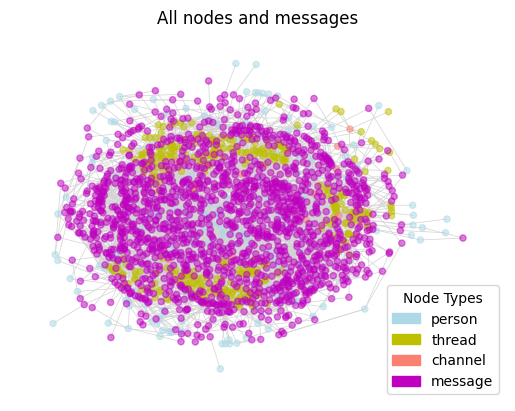

In [98]:
# Try to get position from graphviz
try:
    pos = nx.nx_pydot.graphviz_layout(G, prog="neato")
except Exception as e:
    print(f"Graphviz layout failed, falling back to spring_layout: {e}")
    pos = nx.spring_layout(G, seed=42)
#pos = nx.spring_layout(G, seed=42)
show_graph(G, 
           ["person", "thread", "channel", "message"], 
           pos = pos,
           title = "All nodes and messages")

Inspect whether all message nodes are connected to something.

In [99]:
assert len([node for node in G.nodes() if G.degree(node) == 0 and G.nodes[node]['node_type'] == 'message']) == 0
assert nx.is_connected(G)

---

### Biadjacency Matrix

We'll use the biadjacency matrix in the next few steps, so create a utility for finding it.

In [100]:
import numpy as np
from numpy.typing import NDArray
def get_biadjacency_matrix(G: nx.Graph,
                           row_types: list[str],
                           column_types: list[str]
                           ) -> NDArray[np.float32]:
    # Error handling
    if len(row_types) == 0 or len(column_types) == 0:
        raise ValueError("Must specify node types for both row and column nodes")
    
    # Get list of nodes from each node partition
    list_0: list[Hashable] = sorted([node for node, attrs in G.nodes(data=True) if attrs.get('node_type') in row_types]) 
    if len(list_0) == 0:
        raise ValueError(f"There are no nodes in the graph with types from the row set {row_types}")
    list_1: list[Hashable] = sorted([node for node, attrs in G.nodes(data=True) if attrs.get('node_type') in column_types]) 
    if len(list_1) == 0:
        raise ValueError(f"There are no nodes in the graph with types from the column set {column_types}")


    biadjacency_matrix: NDArray = nx.bipartite.biadjacency_matrix(G, 
                                                                 row_order=list_0, 
                                                                 column_order=list_1).toarray()
    return biadjacency_matrix

---

### Assign Message to Channel 

Since we won't use channels to create the graph of which messages are related to which other messages, we can use the channel as a coarse type of node class.

The algorithm for assigning a class to a node is to find which messages are posted in which channels, either directly or transitively through a thread in a channel. An algorithm that uses biadjacency matrices is 
- Find direct mapping from message to channel
  - compute $B^{[1]}_{\text{message},\text{ channel}}$
- Find mapping from message to channel via thread
  - compute $B_{\text{message},\text{ thread}}$
  - compute $B_{\text{thread},\text{ channel}}$
  - compose to create $B^{[2]}_{\text{message},\text{ channel}} = B_{\text{message},\text{ thread}} B_{\text{thread},\text{ channel}}$
- "Or" the two mappings together $B_{\text{message},\text{ channel}} = B^{[1]}_{\text{message},\text{ channel}} \vee B^{[2]}_{\text{message},\text{ channel}}$

In [101]:
B1_mc = get_biadjacency_matrix(G, ['message'], ['channel'])
B_mt = get_biadjacency_matrix(G, ['message'], ['thread'])
B_tc = get_biadjacency_matrix(G, ['thread'], ['channel'])
B2_mc = B_mt @ B_tc

B_mc = B1_mc | B2_mc

print(B_mc)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Assign messages a channel attribute

In [102]:
# # Sorting makes sure that the order of the nodes in the biadjacency matrices is known
# message_nodes: list[Hashable] = sorted([node for node, attrs in G.nodes(data=True) if attrs.get('node_type') == "message"])
# channel_nodes: list[Hashable] = sorted([node for node, attrs in G.nodes(data=True) if attrs.get('node_type') == "channel"])
# for row in range(B_mc.shape[0]):
#     for column in range(B_mc.shape[1]):
#         if B_mc[row,column] > 0:
#             message_node = message_nodes[row]
#             channel_node = channel_nodes[column]
#             G.nodes[message_node]['node_class'] = G.nodes[channel_node]['node_value']
#             print(f"message node {message_node} is assigned to class {G.nodes[message_node]['node_class']}")

# Every other message node should be 'response', meaning it is a message that is a reply to another post 

Inspect

In [103]:
for node in G.nodes():
    if G.nodes[node]['node_type'] == 'message':
        print(f"Node {node} has type {G.nodes[node]['node_class']}")

Node 530 has type business
Node 531 has type business
Node 532 has type small talk
Node 533 has type business
Node 534 has type business
Node 535 has type business
Node 536 has type business
Node 537 has type business
Node 538 has type business
Node 539 has type code
Node 540 has type math
Node 541 has type exam
Node 542 has type small talk
Node 543 has type business
Node 544 has type business
Node 545 has type small talk
Node 546 has type misc
Node 547 has type business
Node 548 has type business
Node 549 has type business
Node 550 has type business
Node 551 has type business
Node 552 has type business
Node 553 has type business
Node 554 has type small talk
Node 555 has type business
Node 556 has type business
Node 557 has type business
Node 558 has type misc
Node 559 has type project spec
Node 560 has type project spec
Node 561 has type math
Node 562 has type math
Node 563 has type project spec
Node 564 has type business
Node 565 has type project spec
Node 566 has type math
Node 567 

---

### Form "Related Message" Network

#### Step 1: Find Biadjacency Matrix

The graph schema says that two messages posted to the same channel are not closely enough related to be counted as "related". Form the biadjacency matrix for person/thread and message nodes. 

In [104]:
B = get_biadjacency_matrix(G, ['person','thread'], ['message'])

print(B)

[[1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Step 2: Create Adjacency Matrix

Use one-mode projection.

In [105]:
A = B.T@B
np.fill_diagonal(A, 0)
A[A > 1] = 1
print(A)

[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]


#### Step 3: Create Graph 

The adjacency matrix can be used to create a new graph, but the graph will have lost the information about what is in the message nodes. Once we create the graph using the adjacency matrix, add the message information back into the nodes.

In [106]:
G_mm: nx.Graph = nx.from_numpy_array(A)

# Because I sorted the nodes in the "message" partition when I created the 
# biadjacency matrix, I can find a one-to-one mapping from the nodes in the
# new graph and the nodes in the old.

# Get sorted list of message nodes.
node_messages: list[Hashable] = sorted([G.nodes[node]['node_value'] for node in G.nodes() if G.nodes[node]['node_type'] == 'message'])
node_classes: list[Hashable] = sorted([G.nodes[node]['node_class'] for node in G.nodes() if G.nodes[node]['node_type'] == 'message'])

print(f"There are {len(G_mm)} nodes in the new graph.")
print(f"There are {len(node_messages)} message nodes in the old graph.")

for node_index in range(len(G_mm)):
    G_mm.nodes[node_index]['node_type'] = 'message'
    G_mm.nodes[node_index]['node_value'] = node_messages[node_index]
    G_mm.nodes[node_index]['node_class'] = node_classes[node_index]

max_messages: int = 15

for node in G_mm.nodes():
    if G_mm.nodes[node]['node_class'] != np.nan:
        print(f"Message {node}'s class is '{G_mm.nodes[node]['node_class']}'")
        print(f"  The message is '{G_mm.nodes[node]['node_value']}'")
        if node > max_messages:
            break


There are 1517 nodes in the new graph.
There are 1517 message nodes in the old graph.
Message 0's class is 'business'
  The message is '(3,1) and (1,3) are in the relation, but (3,3) is not'
Message 1's class is 'business'
  The message is '**[EDIT]**: I moved this post to the project 1 tab because I felt that it was useful information. The original question was about whether the EOF token should have a newline after it or go straight to the Total Tokens line.'
Message 2's class is 'business'
  The message is '...I'm only now seeing it. I suppose I'll just copy my code from Main to that file?'
Message 3's class is 'business'
  The message is '10'
Message 4's class is 'business'
  The message is '12, 7, 9, 1D right?'
Message 5's class is 'business'
  The message is '2 options:
1
```
Use your diagram to encode the ID FSA to exclude RULES, FACTS, QUERIES, and SCHEMES as IDs
```
2
```
Add a condition in somewhere where if the ID FSA and the FACTS, SCHEMES, RULES, or QUERIES FSA both announ

Take a peak at really short messages to see if there are any glaring problems.

In [107]:
for node in G_mm.nodes():
    if len(G_mm.nodes[node]['node_value']) <= 3:
        print(f"node {node} is a {G_mm.nodes[node]['node_type']} type with message = '{G_mm.nodes[node]['node_value']}'")

node 3 is a message type with message = '10'
node 332 is a message type with message = 'Hi'
node 814 is a message type with message = 'No'
node 815 is a message type with message = 'No'
node 1195 is a message type with message = 'Yes'
node 1196 is a message type with message = 'Yes'
node 1197 is a message type with message = 'Yes'
node 1280 is a message type with message = 'Yup'
node 1281 is a message type with message = 'Yup'
node 1282 is a message type with message = 'Yup'
node 1284 is a message type with message = '\n'
node 1317 is a message type with message = 'eq'
node 1408 is a message type with message = 'no'
node 1409 is a message type with message = 'no'
node 1498 is a message type with message = 'yes'
node 1499 is a message type with message = 'yes'
node 1500 is a message type with message = 'yes'
node 1501 is a message type with message = 'yes'
node 1502 is a message type with message = 'yes'
node 1503 is a message type with message = 'yes'
node 1515 is a message type with m

Try to get the position from graphviz

In [108]:
# try:
#     pos_mm = nx.nx_pydot.graphviz_layout(G_mm, prog="neato")
# except Exception as e:
#     print(f"Graphviz layout failed, falling back to spring_layout: {e}")
#     pos_mm = nx.spring_layout(G_mm, seed=42)
pos_mm = nx.spring_layout(G_mm, seed=42)

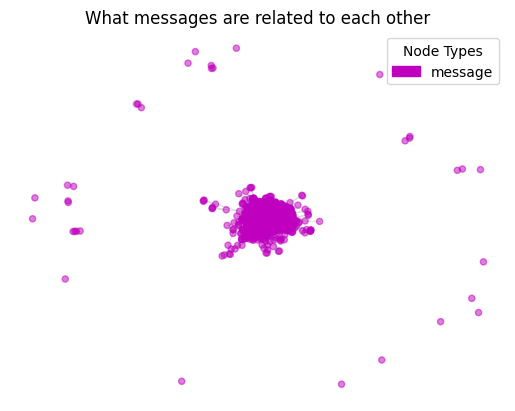

In [109]:
show_graph(G_mm, 
           ["message"], 
           pos = pos_mm,
           title = "What messages are related to each other")

Extract largest component

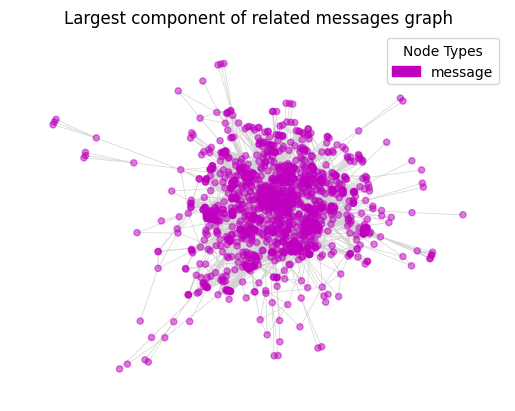

In [110]:
largest_cc = max(nx.connected_components(G_mm), key=len)
# Create a subgraph with only the largest component
largest_subgraph_mm = G_mm.subgraph(largest_cc).copy()
show_graph(largest_subgraph_mm,
           ["message"], 
           pos = pos_mm,
           title = "Largest component of related messages graph")

Show communities

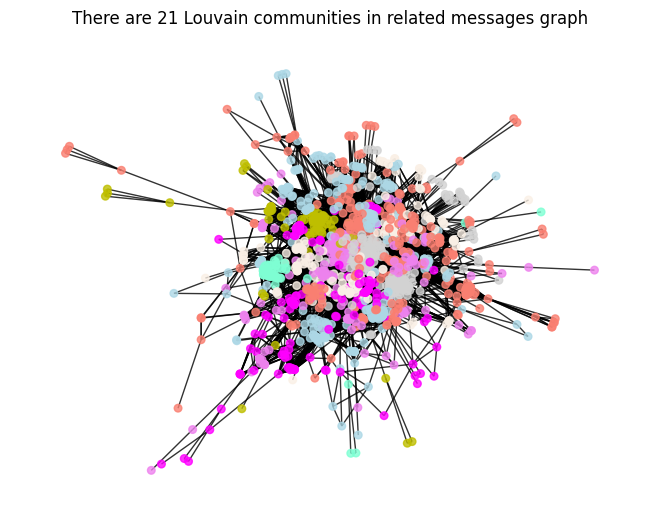

In [111]:
partition = nx.community.louvain_communities(largest_subgraph_mm)
color_list: list[str] = ['y', 'lightblue', 'violet', 'salmon', 
                         'aquamarine', 'magenta', 'lightgray', 'linen']
node_color: list[str] = []
for node in largest_subgraph_mm.nodes():
    for i, group in enumerate(partition):
        if node in group:
            node_color.append(color_list[i%len(color_list)])
            continue
nx.draw(largest_subgraph_mm,
        pos_mm,
        node_color = node_color,
        alpha = 0.8,
        node_size = 30)
_ = plt.title(f"There are {len(partition)} Louvain communities in related messages graph")


Show k-cores diagram to see if the graph has a core-periphery structure.

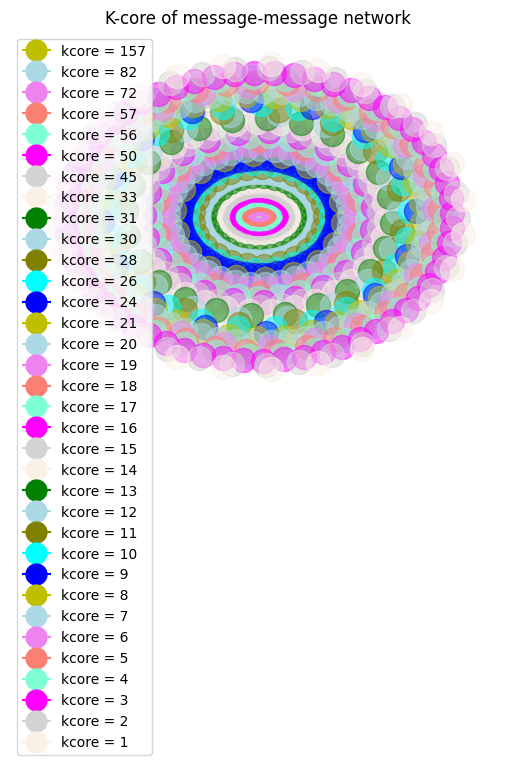

In [112]:
from drawing_utilities import show_kCores
show_kCores(largest_subgraph_mm, title = "K-core of message-message network")

It looks like there is some community structure and that there is a core-periphery structure too. The existence of community structure suggests that we can expect local node neighborhoods to contribute to finding a good node embedding. 

---
---

### Extract Feature Vectors From Messages


#### Step 1: Collect Messages into Corpus


In [113]:
message_texts: list[str] = []
for node in largest_subgraph_mm.nodes():
    message_texts.append(largest_subgraph_mm.nodes[node]['node_value'].replace('\n',' '))

# for _, row in edges_data.iterrows():
#     if row['content'] is not None:
#         message_texts.append(str(row['content']))
for i in range(20):
    print(message_texts[i][:20])

(3,1) and (1,3) are 
**[EDIT]**: I moved 
...I'm only now seei
10
12, 7, 9, 1D right?
2 options: 1 ``` Use
25 points per questi
9, becuse there are 
<@&11265682671762228
<@&11265682671762228
<@106248649760283044
<@114906302237613274
<@190134597370118144
<@190134597370118144
<@372604023921967104
<@534453897956163604
<@534453897956163604
<@681617543563051019
<Person> can't downl
<Person> gave a coup


I asked ChatGPT-4o for a simple way to create a feature vector from the message content of each node. The code below is one of its suggestions.

In [114]:
## Requires pip install sentence-tranformers

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(message_texts, show_progress_bar=True)


Batches: 100%|██████████| 47/47 [00:02<00:00, 20.80it/s]


Inspect size of embeddings.

In [115]:
print(f"There are {len(message_texts)} messages. The embedding dimension is")
print(f"\t{embeddings.shape[0]} = number of messages by")
print(f"\t{embeddings.shape[1]} = feature vector length")
print(embeddings[0])

There are 1483 messages. The embedding dimension is
	1483 = number of messages by
	384 = feature vector length
[-0.18406534 -0.50189614 -0.16623698  0.01270685 -0.36201647 -0.09904558
  0.31763956 -0.73512936  0.4857629  -0.0630236   0.2265947  -0.71312803
  0.00236941  0.30700892  0.33168024  0.06527584 -0.49326456  0.05198391
 -0.2821831  -0.2848306   0.43392208 -0.23530513 -0.45108047  0.379854
  0.16156015  0.0817306   0.22662775  0.17881402  0.14452578  0.15563843
 -0.04181908  0.17239706  0.10566214 -0.23639868 -0.24087627 -0.05319868
 -0.40949324  0.574633    0.16750343  0.39990562  0.17827997 -0.25889614
  0.41824472  0.02962752 -0.24468806  0.49007946 -0.3331005   0.52748966
 -0.07624678 -0.34443623 -0.33115175  0.30529812 -0.19862913  0.44837144
  0.03756953 -0.0819171  -0.32938465  0.12416768 -0.26414225  0.05765919
  0.47130096  0.30839232 -0.33693674  0.3085391   0.48348492 -0.08567718
  0.19115499 -0.16691555 -0.50490195  1.0584974   0.04733671  0.4183081
 -0.23878105 -0.

---
---

## Semi-Supervised Learning

The next natural thing to include would be some labeled nodes so that semi-supervised learning helps organize nodes by type. That provides additional information. There isn't enough time to label messages by hand, and using a more sophisticated labeling tool is beyond the scope of the class. We'll use the classes assigned to the nodes based on whether they were responses or in a channel as rough approximations. Hopefully a GCN can learn enough from the structure of the graph neighborhoods, the semantic similarity of related messages, and a correlation between the classes of related messages.


**Utilities**

The GCN homework found it useful to have some drawing utilities. Let's use those same utilities here.

In [116]:
from matplotlib.axes import Axes
from sklearn.manifold import TSNE

def plot_graph(G: nx.Graph, 
               node_labels: list[int],
               pos: dict[Hashable, tuple[float, float]] | None = None,
               title: str = " ", 
               ax: Axes | None = None) -> None:
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    if ax is None:
        plt.figure()
        ax = plt.gca()
    nx.draw(G, 
            pos = None, 
            node_color=node_labels, 
            cmap=plt.cm.tab10,
            node_size=100, 
            ax = ax, 
            with_labels=False)
    ax.set_title(title)

def plot_scatter(embeddings, labels, title="t-SNE of Node Embeddings", cmap=plt.cm.tab10):
    """Plot a 2D t-SNE scatterplot of node embeddings colored by labels."""
    z = TSNE(n_components=2, perplexity=5, random_state=42).fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    _ = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap=cmap, s=60, edgecolors='k')
    plt.title(title)
    plt.axis('off')
    plt.show()


Let's inspect whether there are correlations in the semantic structures so that such correlations can be used to do semi-supervised learning from feature vectors

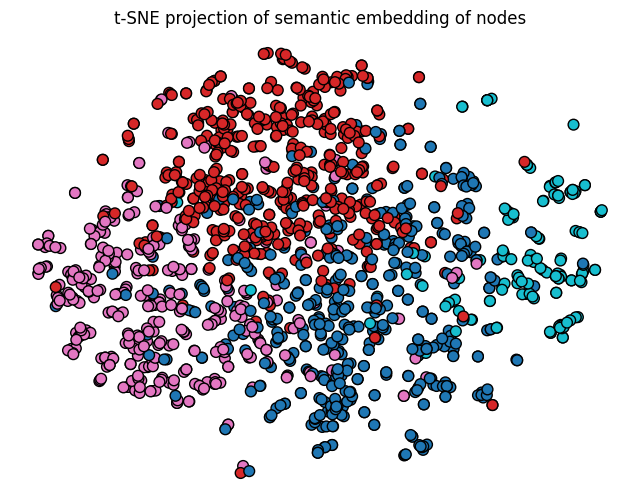

In [117]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, init="random", n_init=10, random_state=1234)

# Assign nodes to classes according to which cluster they belong
cluster_labels = kmeans.fit_predict(embeddings)
plot_scatter(embeddings, cluster_labels, title="t-SNE projection of semantic embedding of nodes")

This plot suggests that there is semantic structure in the node feature vectors that a GCN can use.

Let's see if there is a correlation between semantic correlation in messages and graph structure. 

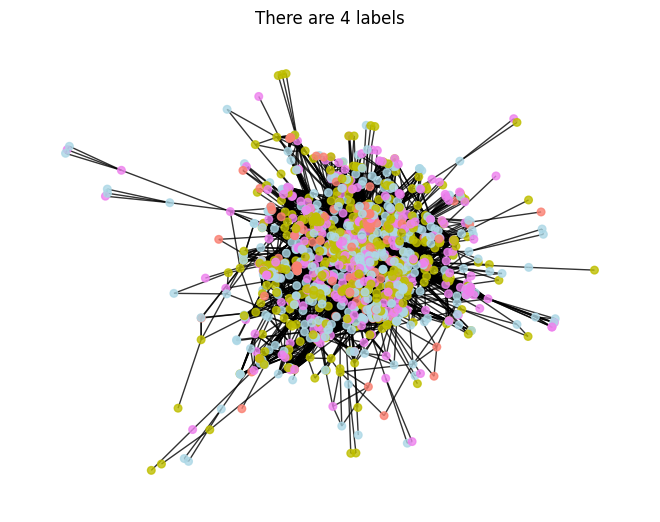

In [118]:
node_color: list[str] = [color_list[i%len(color_list)] for i in cluster_labels]

nx.draw(largest_subgraph_mm,
        pos_mm,
        node_color = node_color,
        alpha = 0.8,
        node_size = 30)
_ = plt.title(f"There are {len(set(cluster_labels))} labels")

It doesn't look like there is a lot of correlation. Hopefully, the GCN will still be able to learn.

---

### Semi-supervised learning

#### Step 1: Get graph and node data into a PyG Structure

Code from ChatGPT-4o

In [120]:
import torch
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Step 1: Convert graph to PyG Data
data: Data = from_networkx(largest_subgraph_mm)

# Step 2: Assign semantic embeddings as node features
data.x = torch.tensor(embeddings, dtype=torch.float)

# Step 3: Encode node_class attributes as integer labels
node_classes = [largest_subgraph_mm.nodes[node]["node_class"] for node in largest_subgraph_mm.nodes()]
label_encoder = LabelEncoder()
data.y = torch.tensor(label_encoder.fit_transform(node_classes), dtype=torch.long)

# Optional check
print(f"data.x shape = {data.x.shape}")
print(f"data.y shape = {data.y.shape}, classes: {label_encoder.classes_}")

data.x shape = torch.Size([1483, 384])
data.y shape = torch.Size([1483]), classes: ['business' 'code' 'configuration' 'exam' 'math' 'misc' 'project spec'
 'small talk' 'unlabeled']


#### Step 2: Choose some nodes for training

Code from ChatGPT-4o

In [132]:
import numpy as np
from collections import defaultdict

# What fraction of nodes will be used for training
node_fraction: float = 0.2

# Step 1: Get class labels and indices (excluding 'unlabeled')
class_indices = defaultdict(list)
unlabeled_class_index = np.where(label_encoder.classes_ == 'unlabeled')[0][0]

for i, y in enumerate(data.y):
    if y != unlabeled_class_index:
        class_indices[int(y)].append(i)

# Step 2: Determine number of samples per class to stay within 20% total
total_nodes = data.num_nodes
max_train_nodes = int(0.2 * total_nodes)
num_classes = len(class_indices)
samples_per_class = max_train_nodes // num_classes

# Step 3: Sample training indices
train_idx = []
for cls, indices in class_indices.items():
    sampled = np.random.choice(indices, size=min(samples_per_class, len(indices)), replace=False)
    train_idx.extend(sampled)

train_idx = torch.tensor(train_idx, dtype=torch.long)

# Optional: create train mask
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
data.train_mask = train_mask
# Optional: check distribution
print(f"Total nodes: {data.num_nodes}")
print(f"Training nodes: {train_mask.sum().item()}")

Total nodes: 1483
Training nodes: 250


#### Step 3: Define GCN

In [133]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
 
# Define GCN with classifier output
class GCNClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden1)
        self.conv2 = GCNConv(hidden1, hidden2)
        self.conv3 = GCNConv(hidden2, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        hidden = F.relu(x)
        x = self.conv3(hidden, edge_index)
        return x, hidden

**Training function**

In [134]:
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out, _ = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item(), out

**Train**


In [135]:
# Instantiate model
model = GCNClassifier(in_channels=data.num_node_features, hidden1=256, hidden2=128, out_channels=len(label_encoder.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train only on labeled nodes
for epoch in range(1, 201):
    loss, out = train(model, data, optimizer)
    
    if epoch % 20 == 0:
        model.eval()
        pred = out.argmax(dim=1)
        acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean().item()
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | Acc (overall): {acc:.4f}")

Epoch  20 | Loss: 0.2817 | Acc (overall): 0.8640
Epoch  40 | Loss: 0.1921 | Acc (overall): 0.9040
Epoch  60 | Loss: 0.1687 | Acc (overall): 0.9120
Epoch  80 | Loss: 0.1559 | Acc (overall): 0.9160
Epoch 100 | Loss: 0.1489 | Acc (overall): 0.9160
Epoch 120 | Loss: 0.1366 | Acc (overall): 0.9320
Epoch 140 | Loss: 0.1327 | Acc (overall): 0.9360
Epoch 160 | Loss: 0.1228 | Acc (overall): 0.9320
Epoch 180 | Loss: 0.1377 | Acc (overall): 0.9280
Epoch 200 | Loss: 0.1228 | Acc (overall): 0.9400


Extract embeddings

Logits shape: torch.Size([1483, 9])
Label shape: torch.Size([1483])
Embedding shape: torch.Size([1483, 128])


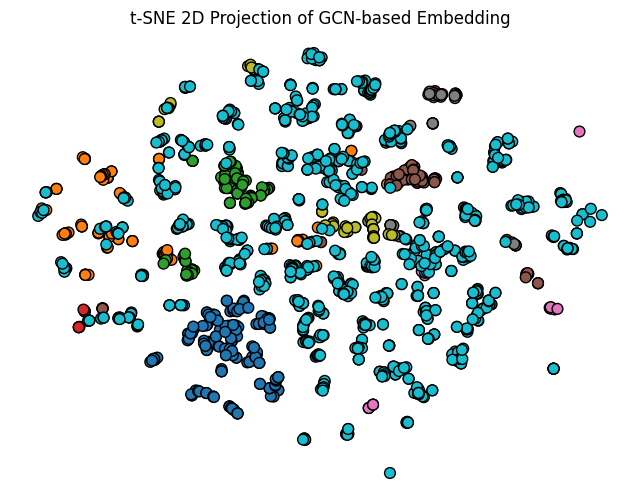

In [136]:
# Extract embeddings (use softmax output or conv2 layer as embedding)
model.eval()
with torch.no_grad():
    logits, node_embeddings = model(data)

print(f"Logits shape: {logits.shape}")
print(f"Label shape: {data.y.shape}")

print(f"Embedding shape: {node_embeddings.shape}")

plot_scatter(node_embeddings, 
             data.y.cpu(),
             title="t-SNE 2D Projection of GCN-based Embedding")

**Show results** for both clustering of the embedding and for running the classifier

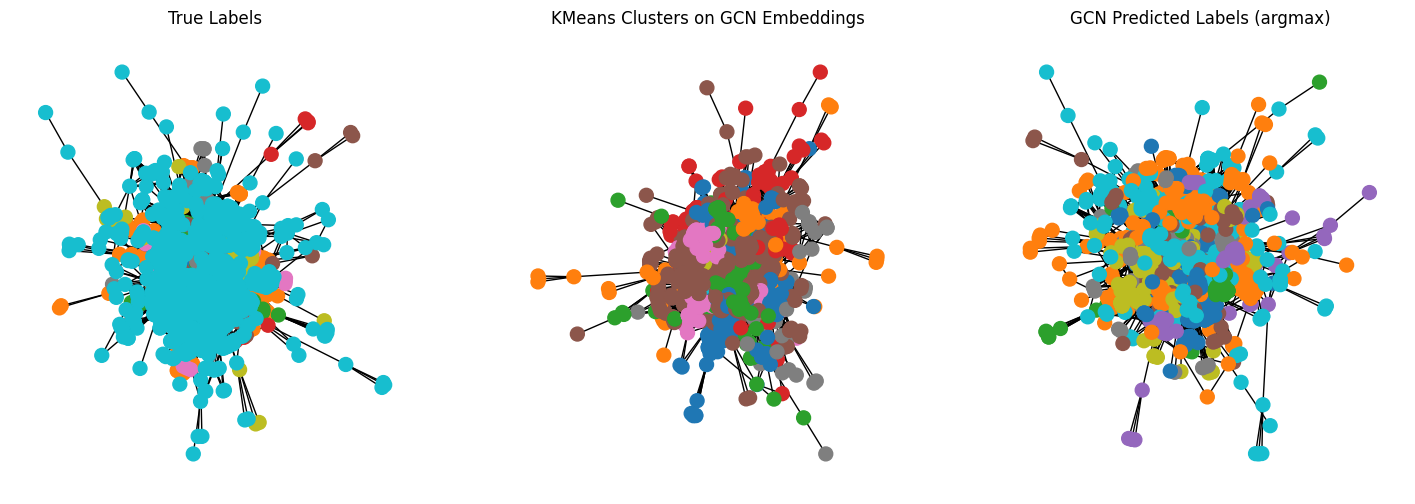

In [137]:
# --- Clustering on embeddings ---
kmeans = KMeans(n_clusters=len(label_encoder.classes_), random_state=0)
cluster_labels_classifier_embedding = kmeans.fit_predict(node_embeddings.cpu().numpy())

# --- Classification prediction ---
predicted_labels = logits.argmax(dim=1).cpu().numpy()

# --- True labels ---
true_labels = data.y.cpu().numpy()

_, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_graph(largest_subgraph_mm, true_labels, pos = pos_mm, title="True Labels", ax=axes[0])
plot_graph(largest_subgraph_mm, cluster_labels_classifier_embedding, pos = pos_mm, title="KMeans Clusters on GCN Embeddings", ax=axes[1])
plot_graph(largest_subgraph_mm, predicted_labels, pos = pos_mm, title="GCN Predicted Labels (argmax)", ax=axes[2])


**ARI scores**

In [138]:
from sklearn.metrics import adjusted_rand_score

# ARI: KMeans on GCN embeddings
ari_kmeans_classifier = adjusted_rand_score(true_labels, cluster_labels_classifier_embedding)

# ARI: Classifier predictions
ari_classifier = adjusted_rand_score(true_labels, predicted_labels)

print(f"Adjusted Rand Index (KMeans on embeddings): {ari_kmeans_classifier:.4f}")
print(f"Adjusted Rand Index (GCN predicted labels): {ari_classifier:.4f}")

Adjusted Rand Index (KMeans on embeddings): 0.1010
Adjusted Rand Index (GCN predicted labels): 0.0935


As the table below shows, an ARI score of 0.67 isn't great but it isn't horrible. 

**Adjusted Rand Index (ARI) Interpretation**

| ARI Score | Interpretation                       |
|-----------|--------------------------------------|
| **1.0**   | Perfect match with true labels       |
| 0.8–0.9   | Excellent clustering                  |
| 0.5–0.7   | Good structure, moderate alignment    |
| 0.2–0.4   | Weak clustering, some structure       |
| **0.0**   | No better than random assignment      |
| **< 0.0** | Worse than random (actively misleading) |

But the goal is not to maximize ARI or even training accuracy. Heck, it's not at all interesting to classify message according to what channel they appear in. And that means there is no reason to suppose that choosing the number of clusters equal to the number of classes is a good idea.

Rather, the goal is to find clusters of messages that have interesting commonalities. We've been trying to combine information from three sources
- commonalities indicated by messages being connected by edges or short paths
- commonalities indicated by similar feature vector
- commonalities indicated by the message types, suggested by the channel

---
---

### Finding Interesting Clusters in Embedding



Let's look at the graph from the clustering done on the hidden layer.

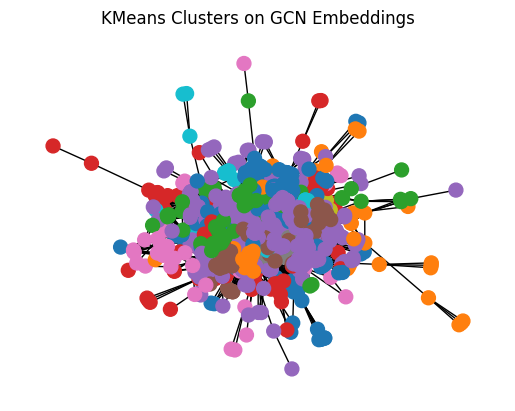

In [149]:
num_clusters: int = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(node_embeddings.cpu().numpy())
plot_graph(largest_subgraph_mm, cluster_labels, pos = pos_mm, title="KMeans Clusters on GCN Embeddings")


Let's select 10 random nodes from each cluster and print out their corresponding messages. Hopefully, we'll be able to see some commonalities.

In [150]:
import random
random.seed(42)
print(f"There are {len(largest_subgraph_mm.nodes)} nodes in the graph and {len(cluster_labels)} labeled nodes")
print(f"The largest node number is {max(G.nodes)}")
print([node for node in largest_subgraph_mm.nodes() if node%100==0])
node_list = list(largest_subgraph_mm.nodes())
print(node_list[-10:])
partition: dict[int, list[Hashable]] = {i: [] for i in range(num_clusters)}
for i, node_class in enumerate(cluster_labels):
    partition[node_class].append(node_list[i])
print(partition)


There are 1483 nodes in the graph and 1483 labeled nodes
The largest node number is 2046
[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
[1506, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516]
{0: [161, 172, 189, 190, 192, 193, 194, 207, 214, 215, 220, 221, 222, 225, 226, 227, 233, 234, 236, 239, 246, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 375, 399, 404, 447, 694, 695, 696, 697, 698, 699, 718, 727, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 

In [151]:
for group, nodes in partition.items():
    node_sample = random.sample(nodes, 10)
    print(f"group {group} has messages:")
    for node in node_sample:
        #print(f"  {node}")
        print(f"    - {largest_subgraph_mm.nodes[node]['node_value'].replace('\n',' ')}")

group 0 has messages:
    - Have you tried including python -m or py -m at the start of the command?
    - Exam format
    - Okay, thanks.
    - Oh gotcha. I am putting it in my Relation class. Do you think that is a bad call? I am debating between that and the Interpreter class becuase it changes the database
    - Is anyone else still having trouble with pytest
    - Here's the zoom link and passcode  https://byu.zoom.us/rec/share/95c6xRyUE5CSaxoeWWfmuSaay_pkIUoYBLHLqwZXGKBMnIKDtks-zE1yFBVycvpS.wN7IuYJK0bQPWg4A   Passcode: N=0bae6+
    - Have you pushed your code?  If that question makes no sense, I can hop on a call and walk you through it all haha.
    - Has anyone else run into import problems with this project? I can't seem to run project3.py, because `from Relation import Relation` throws an error, saying there's no such module, even though I can run Project3RelationsTest.py fine.
    - ``` relation_refrence = self.database[predicate.name] # the above code would make a refrence,

---
---

Below is code written by ChatGPT that tries to use a hierarchical clustering to automatically find clusters. I don't like it because 34 clusters isn't useful to me.

/Users/mike/Dropbox/Mac/Documents/Classes/CS 575/Winter 2025/Code/cs575-homework-1-fall-2025/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mike/Dropbox/Mac/Documents/Classes/CS 575/Winter 2025/Code/cs575-homework-1-fall-2025/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 34 clusters


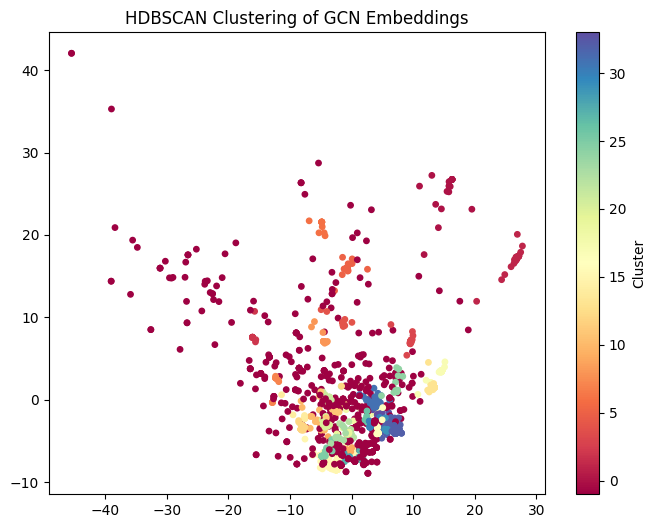

In [152]:
import hdbscan  # Requires pip insteall hdbscan
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Convert embeddings to NumPy for clustering
embedding_array = node_embeddings.cpu().numpy()

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
cluster_labels = clusterer.fit_predict(embedding_array)

# Count number of clusters (ignoring noise label -1)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Found {n_clusters} clusters")

# Visualize with PCA or UMAP
X_pca = PCA(n_components=2).fit_transform(embedding_array)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='Spectral', s=15)
plt.colorbar(label='Cluster')
plt.title('HDBSCAN Clustering of GCN Embeddings')
plt.show()